In [2]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Concat and format all available sensor data into one file

In [11]:
folder_path = '../data/original/sensors'
files = os.listdir(folder_path)

with open('../data/processed/sensors/sensors-acc.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date', 'timestamp', 'sensor_id', 'device_high',
                    'device_middle', 'device_low', 'light', 'sound'])
    for file in files:
        parts = file.split("_")
        date = parts[0]
        id = parts[1].split(".")[0]
        with open('../data/original/sensors/' + file, 'r') as f:
            for line in f:
                line = line.strip()
                parts = line.split(",")
                timestamp = parts[0]
                device_high = parts[1]
                device_middle = parts[2]
                device_low = parts[3]
                light = parts[4]
                sound = parts[5]
                formatted_timestamp = ":".join(
                    [x.zfill(2) for x in timestamp.split(":")])
                writer.writerow([date, formatted_timestamp, id, device_high,
                                 device_middle, device_low, light, sound])

In [24]:
data = pd.read_csv('../data/processed/sensors/sensors-acc.csv')

In [25]:
data['date_timestamp'] = data['date'] + ' ' + data['timestamp']
data.drop(columns=['date', 'timestamp'], inplace=True)

In [26]:
data['date_timestamp'] = pd.to_datetime(data['date_timestamp'], format='%d.%m.%Y %H:%M:%S')

In [27]:
data['date'] = data['date_timestamp'].dt.date
data['time'] = data['date_timestamp'].dt.time

Remove all data falling outside of the experiment timeframe and split into place based frames to make indexing via timestamp possible.

Ids map to the following locations:
1. Ground floor, 3 Round tables by the plants
2. Ground floor, Study Corner next to the plant wall
3. 1st floor, Tables on the landing with wooden floor
4. 1st floor, Yellow/white chairs and tables by the wooden staircase

In [28]:
def process_sensor_data(sensors, sensor_id, start_time='09:00', end_time='16:00'):
    place = sensors.loc[sensors['sensor_id'] == sensor_id]
    place = place.set_index('date_timestamp')
    place = place.between_time(start_time, end_time)
    return place


sensor_ids = [1, 2, 3, 4]
places = {}

for sensor_id in sensor_ids:
    places[sensor_id] = process_sensor_data(data, sensor_id)

# Calibrate Sound Sensor

In [29]:
mic = pd.read_csv('../data/calibration/sound-level/microphone.csv')
sensor = pd.read_csv('../data/calibration/sound-level/sensor.csv')

In [30]:
# format data to same sampling rate
mic['hh:mm:ss.ms'] = pd.to_datetime(mic['hh:mm:ss.ms'], format='%H:%M:%S.%f')
mic = mic.set_index('hh:mm:ss.ms')
resampled_mic = mic.resample('1S').mean()

# align datapints based on alignment clap reading
resampled_mic = resampled_mic.drop(resampled_mic.index[:7])
sensor = sensor.drop(sensor.index[:3])

# only leave data from calibration window
resampled_mic['seq'] = range(1, len(resampled_mic) + 1)
sensor['seq'] = range(1, len(sensor) + 1)
sound_cal = pd.merge(resampled_mic, sensor, on='seq')
sound_cal = sound_cal.drop(sound_cal.index[:14])
sound_cal = sound_cal.iloc[:-7]

/var/folders/fl/z36dzxyn0ql9_2v5cpk99q_c0000gn/T/ipykernel_1153/2036378355.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_mic = mic.resample('1S').mean()


<AxesSubplot: >

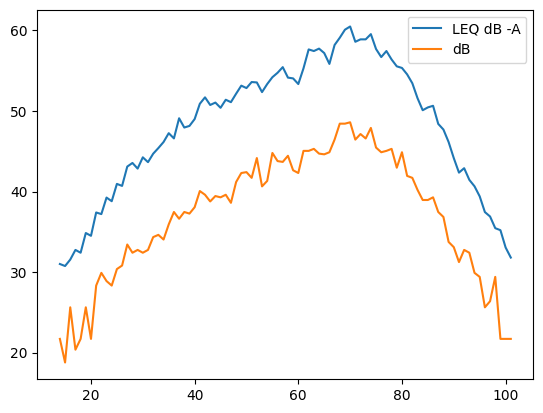

In [31]:
sound_cal.plot(y=["LEQ dB -A","dB"])

<AxesSubplot: >

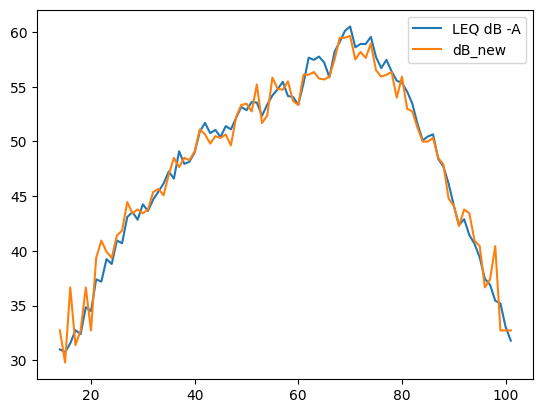

In [32]:
avg_sound_cal_distance = (sound_cal['LEQ dB -A'] - sound_cal['dB']).abs().mean()
sound_cal['dB_new'] = sound_cal['dB'] + avg_sound_cal_distance
sound_cal.plot(y=["LEQ dB -A","dB_new"])

Apply static decible value calibration from sensor-calibration.ipynb

In [33]:
for sensor_id in places:
    places[sensor_id]['sound'] = places[sensor_id]['sound'] + avg_sound_cal_distance

# Light Level Calibration

<AxesSubplot: xlabel='sensor'>

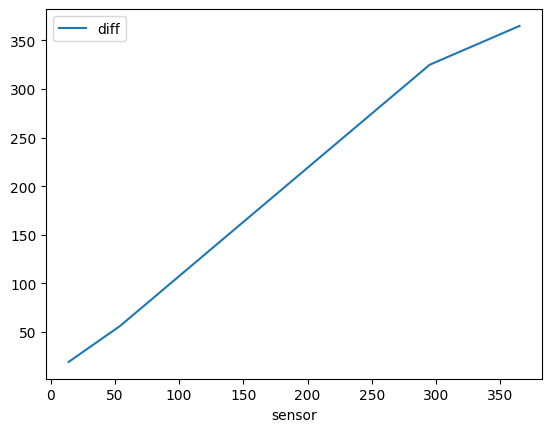

In [34]:
light_cal = pd.read_csv('../data/calibration/ambient-light.csv')
light_cal['diff'] = light_cal['phone'] - light_cal['sensor']
light_cal.plot(y='diff', x='sensor')

In [35]:
coefficients = np.polyfit(light_cal['sensor'], light_cal['diff'], 1)
f = np.poly1d(coefficients)


In [36]:
new_data_points = np.arange(0, 370, 1)
mapping_func = pd.DataFrame(new_data_points, columns=['x'])

# Compute the predicted diff for each of these new data points
mapping_func['predicted_diff'] = f(mapping_func['x'])


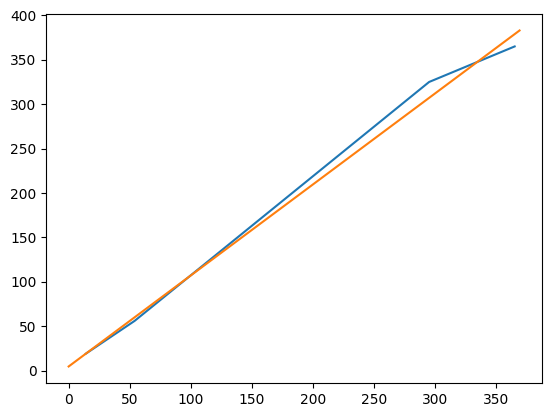

In [37]:
plt.plot(light_cal['sensor'],light_cal['diff'])
plt.plot(mapping_func['x'],mapping_func['predicted_diff'])
plt.show()

In [38]:
for sensor_id in places:
    places[sensor_id]['light'] = places[sensor_id]['light'] + f(places[sensor_id]['light'])

Remove outliers from sound and light data (stem from people moving sensors, covering sensors, shining light onto sensors)

In [39]:

def replace_outliers_with_nan(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    df[column] = np.where((df[column] >= lower_bound) & (df[column] <= upper_bound), df[column], np.nan)
    
    return df

for sensor_id in places:
    places[sensor_id] = replace_outliers_with_nan(places[sensor_id], 'light')

for sensor_id in places:
    places[sensor_id] = replace_outliers_with_nan(places[sensor_id], 'sound')

In [40]:
for sensor_id in places:
    places[sensor_id].to_csv(f'../data/processed/sensors/{sensor_id}-processed.csv')